<h1>Visualizing Clustering/Segmentation in Toronto</h1>


<h2>Installing relevant libraries</h2>


In [1]:
!pip install bs4
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


<h2>Setting up BeautifulSoup with the URL</h2>

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data = requests.get(url).text
soup = BeautifulSoup(data, 'html5lib')


<h2>Scraping Table and assigning it to a Dataframe</h2>

In [3]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
print(df)

    PostalCode                Borough  \
0          M3A             North York   
1          M4A             North York   
2          M5A       Downtown Toronto   
3          M6A             North York   
4          M7A           Queen's Park   
..         ...                    ...   
98         M8X              Etobicoke   
99         M4Y       Downtown Toronto   
100        M7Y  East Toronto Business   
101        M8Y              Etobicoke   
102        M8Z              Etobicoke   

                                          Neighborhood  
0                                            Parkwoods  
1                                     Victoria Village  
2                            Regent Park, Harbourfront  
3                     Lawrence Manor, Lawrence Heights  
4                        Ontario Provincial Government  
..                                                 ...  
98       The Kingsway, Montgomery Road, Old Mill North  
99                                Church and Welles

<h2>Dataframe Shape</h2>

In [4]:
df.shape

(103, 3)

<h2>Creating Dataframe from URL</h2>

In [5]:
url2 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv"
df2 = pd.read_csv(url2)
df["Latitude"] = df2["Latitude"]
df["Longitude"] = df2["Longitude"]


<h2>Importing Libraries and Finding Relevant Information</h2>

In [6]:
!pip install geopy
import geopy as gepoy
from geopy.geocoders import Nominatim
!pip install folium
import folium as folium
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print((latitude, longitude))

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
(43.6534817, -79.3839347)


<h2>Creating Toronto Neighborhoods Map</h2>

In [7]:
map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

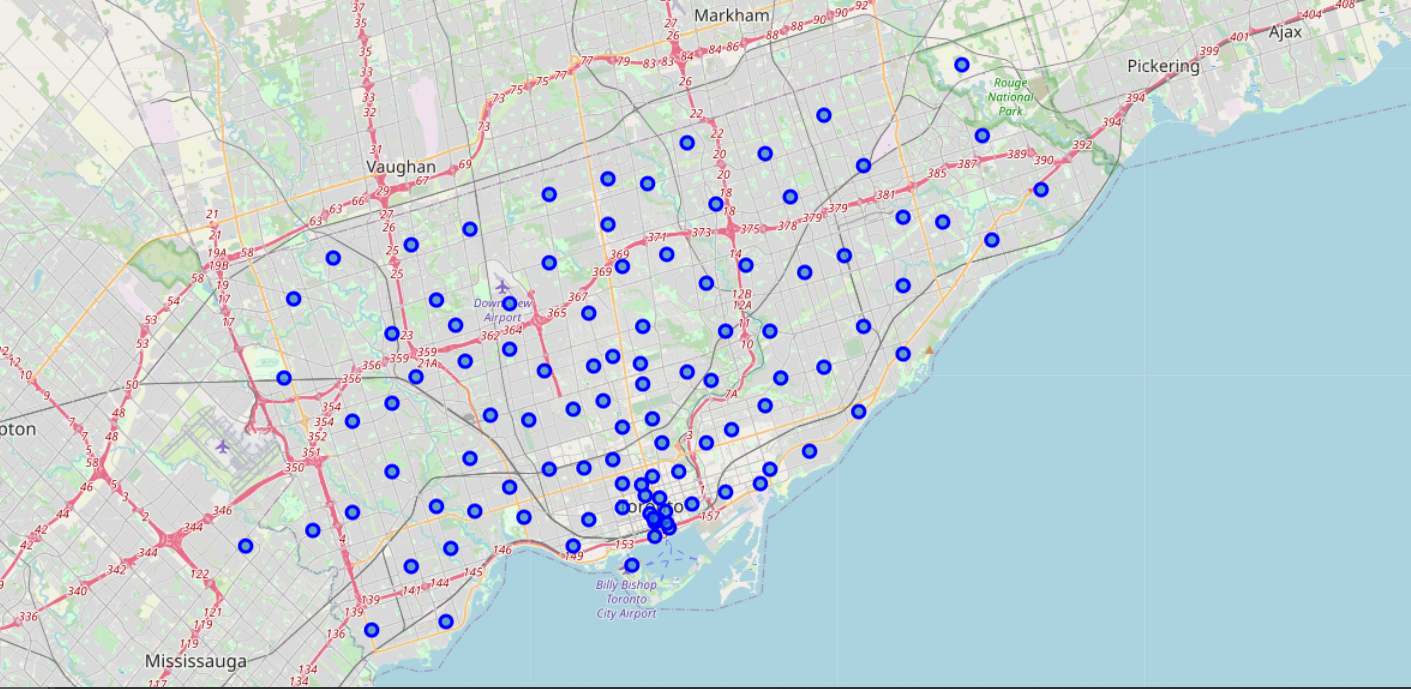

<h2>Performing K Means Clustering</h2>

In [8]:
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt


# set number of clusters
kclusters = 5

coords = df[["Latitude", "Longitude"]]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(coords)
df.insert(0, 'Cluster Labels', kmeans.labels_)

<h2>Visualizing Clusters</h2>

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as colors
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


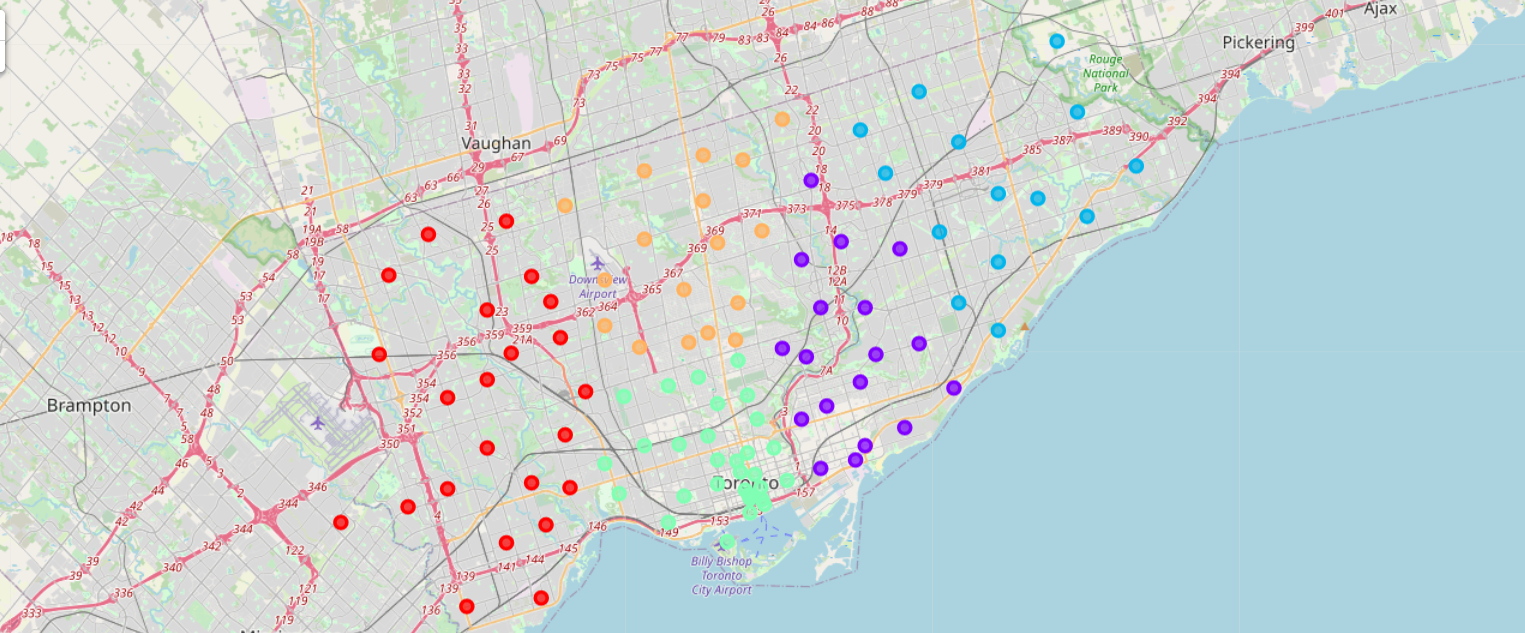